In [1]:
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from dataset import load_core_set_data
from simulation.simulator import FDTDSimulator
from simulation.student import LSTMPredictor, DataTransformer

# 准备数据

## 半径矩阵

```python
radius_save_path = "data/radius_matrix.pth"
```

In [2]:
radius_save_path = "data/radius_matrix.pth"

if os.path.exists(radius_save_path):
    radius_matrix = torch.load(radius_save_path, weights_only=False)
else:
    radius_matrix = torch.rand(10, 10) * 10
    torch.save(radius_matrix, radius_save_path)

print(radius_matrix)


tensor([[4.2537, 7.2491, 6.1717, 9.2729, 4.9853, 9.8473, 3.1820, 9.3614, 8.1104,
         9.0288],
        [2.3149, 8.7649, 5.0795, 8.0234, 4.8227, 8.7122, 0.7336, 2.7354, 7.6845,
         6.5359],
        [6.5778, 9.8060, 0.8749, 7.8437, 6.0056, 7.5152, 8.9349, 6.0827, 4.3046,
         7.7731],
        [0.3096, 1.4307, 0.4254, 2.0687, 3.2475, 0.8592, 9.9883, 3.1064, 7.1883,
         2.8260],
        [6.0670, 4.3900, 8.1416, 5.1876, 1.6904, 2.8222, 9.9509, 8.0686, 6.5593,
         5.9664],
        [9.7981, 5.3376, 9.5862, 0.3684, 5.5181, 7.1683, 3.2136, 5.2784, 1.8340,
         9.4031],
        [2.1909, 0.4959, 9.4064, 1.8535, 2.7756, 7.6035, 9.4730, 6.0837, 7.2479,
         1.7767],
        [2.4067, 8.6760, 5.0395, 6.0531, 6.9528, 0.0580, 0.6878, 2.1934, 4.4764,
         4.8344],
        [4.9628, 6.8850, 0.1238, 5.7276, 2.3660, 0.6239, 9.2926, 6.6920, 3.6652,
         1.5679],
        [2.8365, 5.7207, 1.2948, 2.9172, 4.4617, 8.5791, 4.1536, 8.3898, 6.0025,
         7.9040]])


In [3]:
class FDTDDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


train_data, _, test_data, _ = load_core_set_data()

print(train_data.shape)
print(test_data.shape)

(300, 10)
(50, 10)


## 生成知识蒸馏数据

调用simulator生成蒸馏用标签、调用data_transformer生成蒸馏用输入

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("device: ", device)

assert device == "cuda", "CUDA is not available"

simulator = FDTDSimulator(radius_matrix=radius_matrix)

data_transformer = DataTransformer(device=device)


device:  cuda


### 训练数据生成

In [5]:
train_labels = torch.tensor([], device=device)
train_inputs = torch.tensor([], device=device)
for data in tqdm(train_data):
    inputs = torch.tensor(data)
    outputs = simulator(inputs).detach()
    train_labels = torch.cat((train_labels, outputs), dim=0)

    inputs = data_transformer(inputs).unsqueeze(0)
    train_inputs = torch.cat((train_inputs, inputs), dim=0)

print(train_inputs.shape)
print(train_labels.shape)

  0%|          | 0/300 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [6]:
train_inputs = train_inputs.cpu().numpy()
train_labels = train_labels.cpu().numpy()
train_dataset = FDTDDataset(train_inputs, train_labels)

### 测试数据标签

In [7]:
test_labels = torch.tensor([], device=device)
test_inputs = torch.tensor([], device=device)
for data in tqdm(test_data):
    inputs = torch.tensor(data)
    outputs = simulator(inputs).detach()
    test_labels = torch.cat((test_labels, outputs), dim=0)

    inputs = data_transformer(inputs).unsqueeze(0)
    test_inputs = torch.cat((test_inputs, inputs), dim=0)

print(test_inputs.shape)
print(test_labels.shape)

100%|██████████| 50/50 [07:06<00:00,  8.54s/it]

torch.Size([50, 1000, 11])
torch.Size([50, 1000, 10])


In [8]:
test_inputs = test_inputs.cpu().numpy()
test_labels = test_labels.cpu().numpy()
test_dataset = FDTDDataset(test_inputs, test_labels)

### 保存数据


In [9]:
train_dataset_save_path = "data/train_dataset.pth"
test_dataset_save_path = "data/test_dataset.pth"

torch.save(train_dataset, train_dataset_save_path)
torch.save(test_dataset, test_dataset_save_path)

In [6]:
train_dataset_save_path = "data/train_dataset.pth"
test_dataset_save_path = "data/test_dataset.pth"

train_dataset = torch.load(train_dataset_save_path, weights_only=False)
test_dataset = torch.load(test_dataset_save_path, weights_only=False)

# 设置PyTorch默认数据类型为float32
torch.set_default_dtype(torch.float32)

# 训练模型

In [7]:
model = LSTMPredictor(
    input_size=10,
    hidden_size=128,
    output_size=10,
    num_layers=2,
    dropout=0.1
).to(device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
# 可以在模型初始化后添加这段代码来检查参数类型
for name, param in model.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

lstm.weight_ih_l0 requires_grad: True
lstm.weight_hh_l0 requires_grad: True
lstm.bias_ih_l0 requires_grad: True
lstm.bias_hh_l0 requires_grad: True
lstm.weight_ih_l1 requires_grad: True
lstm.weight_hh_l1 requires_grad: True
lstm.bias_ih_l1 requires_grad: True
lstm.bias_hh_l1 requires_grad: True
output_layer.weight requires_grad: True
output_layer.bias requires_grad: True


In [22]:
num_epochs = 10000
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [13]:
total_steps = num_epochs * len(train_loader)
progress_bar = tqdm(total=total_steps, desc="Training Progress")

last_epoch_loss = ""

with torch.enable_grad():
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.update(1)
            progress_bar.set_description(f"Batch Loss: {loss.item():.6f}   " + last_epoch_loss)

        last_epoch_loss = f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss/len(train_loader):.6f}"


progress_bar.close()

Batch Loss: 0.020566   Epoch 249/10000 Loss: 0.021052:   2%|▏         | 2491/100000 [01:29<1:03:20, 25.65it/s]

# 保存模型

```python
model_save_path = "data/model.pth"
```


In [14]:
model_save_path = "data/model.pth"
torch.save(model.state_dict(), model_save_path)

# 测试模型



In [19]:
model_save_path = "data/model.pth"
model = LSTMPredictor(
    input_size=10,
    hidden_size=128,
    output_size=10,
    num_layers=2,
    dropout=0.1
).to(device)
model.load_state_dict(torch.load(model_save_path, weights_only=True))
model.eval()

/tmp/ipykernel_36004/3025858934.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


LSTMPredictor(
  (lstm): LSTM(11, 128, num_layers=2, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
test_loss = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        all_preds.append(outputs.cpu())
        all_labels.append(labels.cpu())

# 计算平均测试损失
avg_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {avg_test_loss:.6f}")

Average Test Loss: 0.027522


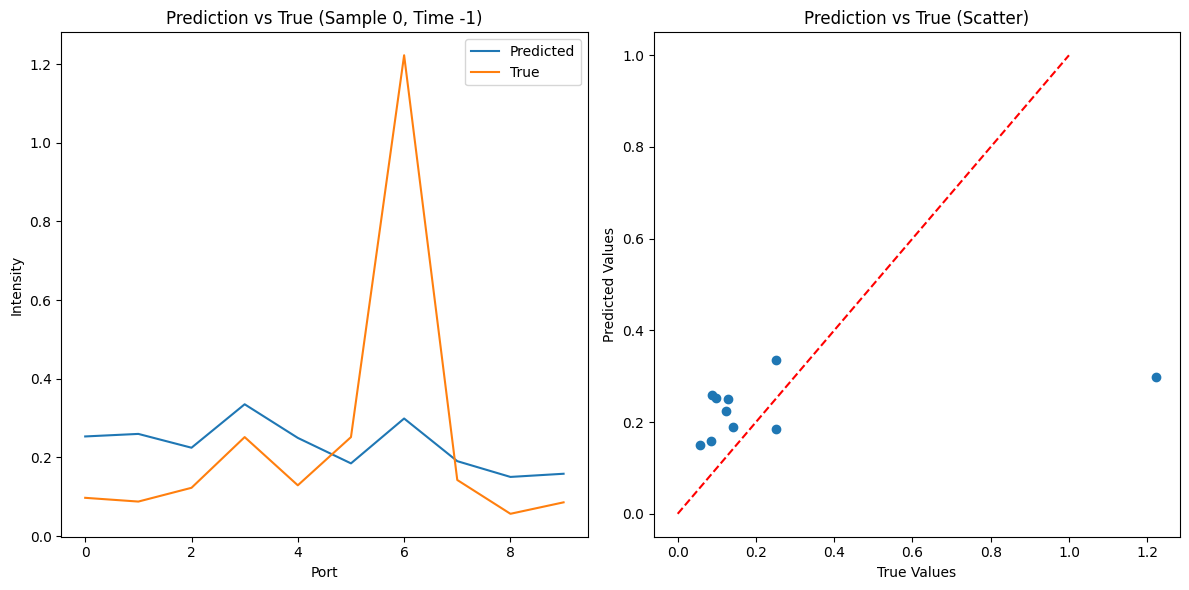

Mean Squared Error: 0.027369
Mean Absolute Error: 0.076975
R² Score: 0.403714


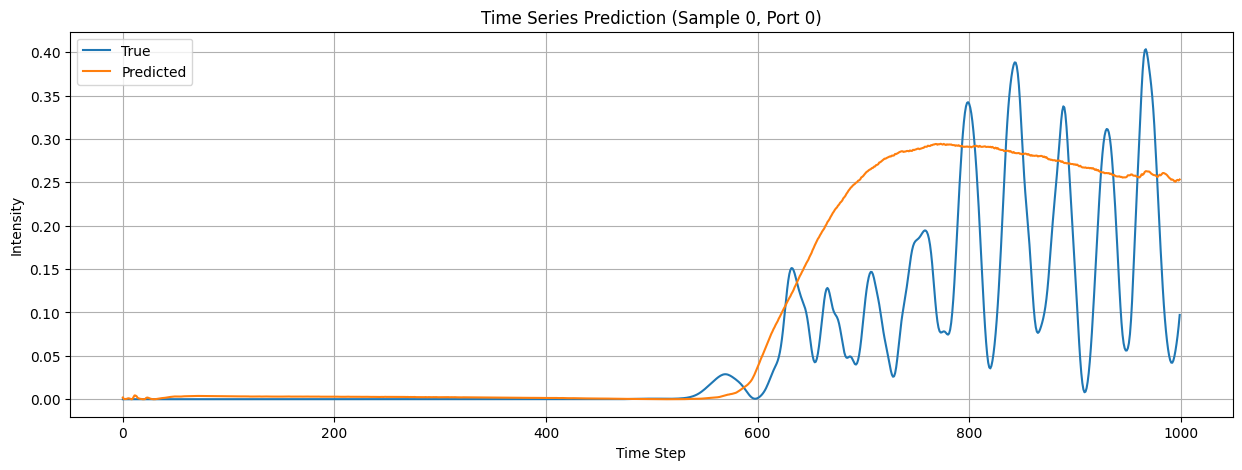

In [21]:
# 将预测和标签转换为numpy数组以便绘图
all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# 绘制预测结果与真实值的对比
plt.figure(figsize=(12, 6))

# 选择一个样本和时间点进行可视化
sample_idx = 0  # 可以改变这个索引来查看不同的样本
time_step = -1  # -1表示最后一个时间步

# 绘制预测值和真实值的对比
plt.subplot(1, 2, 1)
plt.plot(all_preds[sample_idx, time_step], label='Predicted')
plt.plot(all_labels[sample_idx, time_step], label='True')
plt.title(f'Prediction vs True (Sample {sample_idx}, Time {time_step})')
plt.xlabel('Port')
plt.ylabel('Intensity')
plt.legend()

# 绘制散点图
plt.subplot(1, 2, 2)
plt.scatter(all_labels[sample_idx, time_step], all_preds[sample_idx, time_step])
plt.plot([0, 1], [0, 1], 'r--')  # 理想的对角线
plt.title('Prediction vs True (Scatter)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

# 计算一些统计指标
mse = np.mean((all_preds - all_labels) ** 2)
mae = np.mean(np.abs(all_preds - all_labels))
r2 = 1 - np.sum((all_preds - all_labels) ** 2) / np.sum((all_labels - np.mean(all_labels)) ** 2)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

# 可视化时序预测
plt.figure(figsize=(15, 5))
time_steps = np.arange(all_preds.shape[1])
port_idx = 0  # 可以改变这个索引来查看不同端口的预测

plt.plot(time_steps, all_labels[sample_idx, :, port_idx], label='True')
plt.plot(time_steps, all_preds[sample_idx, :, port_idx], label='Predicted')
plt.title(f'Time Series Prediction (Sample {sample_idx}, Port {port_idx})')
plt.xlabel('Time Step')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()
